In [19]:
import sys
from pathlib import Path

parent_dir = str(Path().absolute().parent)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import umap
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# Set up plotting style consistent with existing notebooks
sns.set_theme(
    style='ticks', 
    rc={
    "text.usetex": False,
    "font.family": "serif",
    "axes.grid": True,
    "lines.linewidth": 0.8,
    'axes.linewidth':0.8,
    'grid.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3.0,
    'ytick.major.size': 3.0,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.edgecolor": "black"
    },
    palette='deep',
)
sns.set_palette('Set2')


In [21]:
from src.utils import find_root
from src.dataset.load import load_dataset_col_trf
from src.classification.classify import fit_evaluate_classifier

# Set up paths and parameters
BASE_PATH = find_root()
DATASET_TAG = 'adult'
SENSITIVE_FEAT = 'sex'
CAUSAL_WORLD_ID = 5  # Causal world with highest quality metrics
CLASSIFIER = 'FAIRGBM'

print(f"Base path: {BASE_PATH}")
print(f"Dataset: {DATASET_TAG}")
print(f"Sensitive feature: {SENSITIVE_FEAT}")
print(f"Target causal world: {CAUSAL_WORLD_ID}")
print(f"Classifier: {CLASSIFIER}")


Base path: /home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty
Dataset: adult
Sensitive feature: sex
Target causal world: 5
Classifier: FAIRGBM


# UMAP Dimensionality Reduction Analysis

This notebook explores the UMAP dimensionality reduction of the Adult dataset test data and counterfactuals from causal world 5. The visualizations are colored by sex (Female/Male) and use markers based on FAIRGBM model predictions.

## Objectives:
1. Load test dataset and counterfactuals from causal world 5
2. Apply UMAP dimensionality reduction
3. Visualize results with sex-based coloring and prediction-based markers
4. Analyze the relationship between original data and counterfactuals in the reduced space


In [22]:
# Load the encoded dataset
print("Loading Adult dataset...")
enc_dataset, col_trf = load_dataset_col_trf(DATASET_TAG)

print(f"Test data shape: {enc_dataset.X_enc_test.shape}")
print(f"Test data columns: {list(enc_dataset.X_enc_test.columns)}")
print(f"Sensitive feature values: {enc_dataset.sensitive_test.value_counts()}")
print(f"Target distribution: {enc_dataset.y_test.value_counts()}")

# Display first few rows of test data
print("\nFirst few rows of encoded test data:")
enc_dataset.X_enc_test.head()


Loading Adult dataset...
Test data shape: (9769, 106)
Test data columns: ['scale__age', 'scale__education-num', 'scale__capital-gain', 'scale__capital-loss', 'scale__hours-per-week', 'onehot__workclass_Federal-gov', 'onehot__workclass_Local-gov', 'onehot__workclass_Missing', 'onehot__workclass_Never-worked', 'onehot__workclass_Private', 'onehot__workclass_Self-emp-inc', 'onehot__workclass_Self-emp-not-inc', 'onehot__workclass_State-gov', 'onehot__workclass_Without-pay', 'onehot__education_10th', 'onehot__education_11th', 'onehot__education_12th', 'onehot__education_1st-4th', 'onehot__education_5th-6th', 'onehot__education_7th-8th', 'onehot__education_9th', 'onehot__education_Assoc-acdm', 'onehot__education_Assoc-voc', 'onehot__education_Bachelors', 'onehot__education_Doctorate', 'onehot__education_HS-grad', 'onehot__education_Masters', 'onehot__education_Preschool', 'onehot__education_Prof-school', 'onehot__education_Some-college', 'onehot__marital-status_Divorced', 'onehot__marital-st

,scale__age,scale__education-num,scale__capital-gain,scale__capital-loss,scale__hours-per-week,onehot__workclass_Federal-gov,onehot__workclass_Local-gov,onehot__workclass_Missing,onehot__workclass_Never-worked,onehot__workclass_Private,...,onehot__native-country_Portugal,onehot__native-country_Puerto-Rico,onehot__native-country_Scotland,onehot__native-country_South,onehot__native-country_Taiwan,onehot__native-country_Thailand,onehot__native-country_Trinadad&Tobago,onehot__native-country_United-States,onehot__native-country_Vietnam,onehot__native-country_Yugoslavia
40342,1.113755,-0.419324,-0.144218,-0.220137,-0.036809,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47680,-0.778552,-0.419324,-0.144218,-0.220137,-1.647633,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
524,1.040974,-0.030796,-0.144218,-0.220137,0.768604,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8508,1.404879,-0.419324,0.283608,-0.220137,-1.969798,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31692,0.604288,0.746262,-0.144218,-0.220137,-0.036809,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
# Load counterfactuals from causal world 5
print("Loading multi-world counterfactuals...")
mw_counterfactuals_fpath = BASE_PATH / f"output/{DATASET_TAG}/med/mw_counterfactuals.pkl"

with open(mw_counterfactuals_fpath, 'rb') as f:
    mw_counterfactuals = pickle.load(f)

print(f"Total counterfactuals shape: {mw_counterfactuals.counterfactuals.shape}")
print(f"Available causal worlds: {mw_counterfactuals.get_causal_world_ids()}")

# Extract counterfactuals from causal world 5
cf_world_5 = mw_counterfactuals.counterfactuals.loc[CAUSAL_WORLD_ID]
print(f"\nCounterfactuals from causal world {CAUSAL_WORLD_ID}:")
print(f"Shape: {cf_world_5.shape}")
print(f"Columns: {list(cf_world_5.columns)}")

# Display first few rows
cf_world_5.head()


Loading multi-world counterfactuals...
Total counterfactuals shape: (322377, 106)
Available causal worlds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Counterfactuals from causal world 5:
Shape: (9769, 106)
Columns: ['scale__age', 'scale__education-num', 'scale__capital-gain', 'scale__capital-loss', 'scale__hours-per-week', 'onehot__workclass_Federal-gov', 'onehot__workclass_Local-gov', 'onehot__workclass_Missing', 'onehot__workclass_Never-worked', 'onehot__workclass_Private', 'onehot__workclass_Self-emp-inc', 'onehot__workclass_Self-emp-not-inc', 'onehot__workclass_State-gov', 'onehot__workclass_Without-pay', 'onehot__education_10th', 'onehot__education_11th', 'onehot__education_12th', 'onehot__education_1st-4th', 'onehot__education_5th-6th', 'onehot__education_7th-8th', 'onehot__education_9th', 'onehot__education_Assoc-acdm', 'onehot__education_Assoc-voc', 'onehot__education_Bachelors', 'onehot__education

,scale__age,scale__education-num,scale__capital-gain,scale__capital-loss,scale__hours-per-week,onehot__workclass_Federal-gov,onehot__workclass_Local-gov,onehot__workclass_Missing,onehot__workclass_Never-worked,onehot__workclass_Private,...,onehot__native-country_Portugal,onehot__native-country_Puerto-Rico,onehot__native-country_Scotland,onehot__native-country_South,onehot__native-country_Taiwan,onehot__native-country_Thailand,onehot__native-country_Trinadad&Tobago,onehot__native-country_United-States,onehot__native-country_Vietnam,onehot__native-country_Yugoslavia
individual,,,,,,,,,,,,,,,,,,,,,
40342,1.113755,-0.504414,-0.095553,-0.188204,0.287512,-0.012453,-0.001699,-0.030858,-0.000085,1.015948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
47680,-0.778552,-0.334234,-0.192884,-0.252071,-1.971954,0.012453,1.001699,0.030858,0.000085,-0.015948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
524,1.040974,0.054294,-0.192884,-0.252071,0.444282,0.012453,1.001699,0.030858,0.000085,-0.015948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8508,1.404879,-0.334234,0.234943,-0.252071,-2.294119,0.012453,0.001699,0.030858,0.000085,0.984052,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31692,0.604288,0.831352,-0.192884,-0.252071,-0.361130,0.012453,1.001699,0.030858,0.000085,-0.015948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
# Load and fit FAIRGBM classifier to get predictions
print("Loading FAIRGBM classifier...")

# Check if FAIRGBM model already exists
model_output_dir = '/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/output/adult/model_metrics/FAIRGBM'
model_path = Path(model_output_dir) / "fairgbm_model.pkl"

if model_path.exists():
    print("Loading existing FAIRGBM model...")
    with open(model_path, 'rb') as f:
        fairgbm_classifier = pickle.load(f)
    
    # Get predictions
    y_pred = pd.Series(
        fairgbm_classifier.predict(enc_dataset.X_enc_test),
        index=enc_dataset.X_enc_test.index,
        name='fairgbm_prediction'
    )

print(f"FAIRGBM predictions shape: {y_pred.shape}")
print(f"Prediction distribution: {y_pred.value_counts()}")
print(f"Prediction accuracy: {(y_pred == enc_dataset.y_test).mean():.4f}")


Loading FAIRGBM classifier...
Loading existing FAIRGBM model...
[LightGBM] [Warning] The objective function 'constrained_cross_entropy' was not properly loaded. Resuming training is not available; everything else can be used as usual.
FAIRGBM predictions shape: (9769,)
Prediction distribution: fairgbm_prediction
0    7538
1    2231
Name: count, dtype: int64
Prediction accuracy: 0.8582


In [27]:
enc_dataset.X_enc_test.head()['onehot__sex_Male']

40342    0.0
47680    1.0
524      1.0
8508     1.0
31692    1.0
Name: onehot__sex_Male, dtype: float64

In [7]:
# Prepare dataset for UMAP analysis
print("Preparing dataset for UMAP analysis...")

# Ensure counterfactuals have the same individuals as test data
common_individuals = cf_world_5.index.intersection(enc_dataset.X_enc_test.index)
print(f"Common individuals between test data and counterfactuals: {len(common_individuals)}")

# Filter to common individuals
test_data_filtered = enc_dataset.X_enc_test
cf_data_filtered = cf_world_5

# Use ONLY test data features for UMAP fitting
print("Using only test data features for UMAP fitting...")
features_for_umap = test_data_filtered.copy()
print(f"Features for UMAP (test data only): {features_for_umap.shape}")

# Extract sex from encoded features for both datasets
print("Extracting sex information from encoded features...")

# For test data - get original sex
test_sex = enc_dataset.sensitive_test

# For counterfactuals - extract sex from encoded features
# Counterfactuals have different sex values due to interventions
cf_sex_male = cf_data_filtered['onehot__sex_Male']
cf_sex = cf_sex_male.map({1: 'Male', 0: 'Female'})

# Get FAIRGBM predictions for both datasets
print("Getting FAIRGBM predictions for both datasets...")

# Original predictions (from test data)
test_predictions = y_pred

# Counterfactual predictions (need to predict on counterfactual data)
print("Predicting on counterfactual data...")
cf_predictions = pd.Series(
    fairgbm_classifier.predict(cf_data_filtered),
    index=cf_data_filtered.index,
    name='fairgbm_prediction'
)

# Create metadata for visualization
test_data_with_meta = test_data_filtered.copy()
test_data_with_meta['data_type'] = 'original'
test_data_with_meta['sex'] = test_sex
test_data_with_meta['fairgbm_pred'] = test_predictions
test_data_with_meta['individual_id'] = test_data_filtered.index

cf_data_with_meta = cf_data_filtered.copy()
cf_data_with_meta['data_type'] = 'counterfactual'
cf_data_with_meta['sex'] = cf_sex
cf_data_with_meta['fairgbm_pred'] = cf_predictions
cf_data_with_meta['individual_id'] = cf_data_filtered.index

# Combine datasets for visualization metadata
combined_data = pd.concat([test_data_with_meta, cf_data_with_meta], axis=0)
print(f"Combined dataset shape (for visualization): {combined_data.shape}")

# Extract metadata for visualization
metadata = combined_data[['data_type', 'sex', 'fairgbm_pred', 'individual_id']]

print(f"Features for UMAP: {len(features_for_umap.columns)}")
print(f"Feature columns: {list(features_for_umap.columns)[:5]}...")  # Show first 5 features
print(f"Metadata columns: {list(metadata.columns)}")

# Display summary
print(f"\nData type distribution:")
print(combined_data['data_type'].value_counts())
print(f"\nSex distribution (original vs counterfactual):")
print(combined_data.groupby('data_type')['sex'].value_counts())
print(f"\nFAIRGBM prediction distribution (original vs counterfactual):")
print(combined_data.groupby('data_type')['fairgbm_pred'].value_counts())

# Show the differences in sex and predictions
print(f"\nSex changes due to counterfactual interventions:")
print(f"Original sex distribution: {test_sex.value_counts().to_dict()}")
print(f"Counterfactual sex distribution: {cf_sex.value_counts().to_dict()}")

print(f"\nPrediction changes due to counterfactual interventions:")
print(f"Original prediction distribution: {test_predictions.value_counts().to_dict()}")
print(f"Counterfactual prediction distribution: {cf_predictions.value_counts().to_dict()}")


Preparing dataset for UMAP analysis...
Common individuals between test data and counterfactuals: 9769
Using only test data features for UMAP fitting...
Features for UMAP (test data only): (9769, 106)
Extracting sex information from encoded features...
Getting FAIRGBM predictions for both datasets...
Predicting on counterfactual data...
Combined dataset shape (for visualization): (19538, 110)
Features for UMAP: 106
Feature columns: ['scale__age', 'scale__education-num', 'scale__capital-gain', 'scale__capital-loss', 'scale__hours-per-week']...
Metadata columns: ['data_type', 'sex', 'fairgbm_pred', 'individual_id']

Data type distribution:
data_type
original          9769
counterfactual    9769
Name: count, dtype: int64

Sex distribution (original vs counterfactual):
data_type       sex   
counterfactual  Female    6510
                Male      3259
original        Male      6510
                Female    3259
Name: count, dtype: int64

FAIRGBM prediction distribution (original vs counte

In [8]:
enc_dataset.X_enc_test['onehot__sex_Male'].value_counts()

onehot__sex_Male
1.0    6510
0.0    3259
Name: count, dtype: int64

In [9]:
cf_world_5['onehot__sex_Male'].value_counts()

onehot__sex_Male
0.0    6510
1.0    3259
Name: count, dtype: int64

In [10]:
# Apply UMAP dimensionality reduction
print("Applying UMAP dimensionality reduction...")

# Initialize UMAP with parameters optimized for visualization
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='euclidean',
    random_state=42,
    verbose=True
)

# Fit UMAP on test data only
print("Fitting UMAP on test data...")
umap_reducer.fit(features_for_umap)

# Transform both test data and counterfactuals using the fitted UMAP
print("Transforming test data and counterfactuals...")
test_umap = umap_reducer.transform(test_data_filtered)
cf_umap = umap_reducer.transform(cf_data_filtered)
all_umap = np.vstack([test_umap, cf_umap])

print(f"UMAP embedding shape: {all_umap.shape}")

# Create DataFrame with UMAP coordinates and metadata
umap_df = pd.DataFrame({
    'umap_1': all_umap[:, 0],
    'umap_2': all_umap[:, 1],
    'data_type': metadata['data_type'].values,
    'sex': metadata['sex'].values,
    'fairgbm_pred': metadata['fairgbm_pred'].values,
    'individual_id': metadata['individual_id'].values
})

print("UMAP embedding completed!")
print(f"UMAP DataFrame shape: {umap_df.shape}")
print(f"UMAP coordinate ranges:")
print(f"  UMAP 1: [{umap_df['umap_1'].min():.3f}, {umap_df['umap_1'].max():.3f}]")
print(f"  UMAP 2: [{umap_df['umap_2'].min():.3f}, {umap_df['umap_2'].max():.3f}]")

# Display first few rows
umap_df.head()


Applying UMAP dimensionality reduction...
Fitting UMAP on test data...
UMAP(n_jobs=1, random_state=42, verbose=True)
Thu Sep 25 21:16:55 2025 Construct fuzzy simplicial set
Thu Sep 25 21:16:55 2025 Finding Nearest Neighbors
Thu Sep 25 21:16:55 2025 Building RP forest with 10 trees


/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Thu Sep 25 21:17:00 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Thu Sep 25 21:17:09 2025 Finished Nearest Neighbor Search
Thu Sep 25 21:17:11 2025 Construct embedding


Epochs completed:   1%| ▏          7/500 [00:01]

	completed  0  /  500 epochs


Epochs completed:  12%| █▏         62/500 [00:02]

	completed  50  /  500 epochs


Epochs completed:  22%| ██▏        112/500 [00:03]

	completed  100  /  500 epochs


Epochs completed:  32%| ███▏       162/500 [00:04]

	completed  150  /  500 epochs


Epochs completed:  42%| ████▏      212/500 [00:05]

	completed  200  /  500 epochs


Epochs completed:  53%| █████▎     264/500 [00:06]

	completed  250  /  500 epochs


Epochs completed:  63%| ██████▎    314/500 [00:07]

	completed  300  /  500 epochs


Epochs completed:  72%| ███████▏   361/500 [00:08]

	completed  350  /  500 epochs


Epochs completed:  82%| ████████▏  412/500 [00:10]

	completed  400  /  500 epochs


Epochs completed:  92%| █████████▏ 462/500 [00:11]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:12]
/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Thu Sep 25 21:17:23 2025 Finished embedding
Transforming test data and counterfactuals...
Thu Sep 25 21:17:24 2025 Worst tree score: 0.77715222
Thu Sep 25 21:17:24 2025 Mean tree score: 0.78783908
Thu Sep 25 21:17:24 2025 Best tree score: 0.80325520
Thu Sep 25 21:17:26 2025 Forward diversification reduced edges from 146535 to 47987
Thu Sep 25 21:17:28 2025 Reverse diversification reduced edges from 47987 to 47987
Thu Sep 25 21:17:30 2025 Degree pruning reduced edges from 50620 to 50620
Thu Sep 25 21:17:30 2025 Resorting data and graph based on tree order
Thu Sep 25 21:17:30 2025 Building and compiling search function


Epochs completed:   7%| ▋          7/100 [00:00]

	completed  0  /  100 epochs


Epochs completed:  20%| ██         20/100 [00:00]

	completed  10  /  100 epochs


Epochs completed:  32%| ███▏       32/100 [00:00]

	completed  20  /  100 epochs
	completed  30  /  100 epochs


Epochs completed:  48%| ████▊      48/100 [00:01]

	completed  40  /  100 epochs


Epochs completed:  61%| ██████     61/100 [00:01]

	completed  50  /  100 epochs
	completed  60  /  100 epochs


Epochs completed:  76%| ███████▌   76/100 [00:01]

	completed  70  /  100 epochs


Epochs completed:  86%| ████████▌  86/100 [00:02]

	completed  80  /  100 epochs


Epochs completed: 100%| ██████████ 100/100 [00:02]

	completed  90  /  100 epochs
UMAP embedding shape: (19538, 2)
UMAP embedding completed!
UMAP DataFrame shape: (19538, 6)
UMAP coordinate ranges:
  UMAP 1: [-7.145, 17.689]
  UMAP 2: [-8.406, 14.624]


,umap_1,umap_2,data_type,sex,fairgbm_pred,individual_id
0,14.739665,1.437672,original,Female,1,40342
1,5.207281,3.783207,original,Male,0,47680
2,8.893856,-4.216489,original,Male,1,524
3,12.131340,-3.147464,original,Male,0,8508
4,16.830620,12.513329,original,Male,1,31692


In [ ]:
# Create visualization functions
def create_umap_plot(data, title, save_path=None, show_legend=True):
    """Create UMAP scatter plot with sex-based coloring and prediction-based markers."""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define colors for sex
    sex_colors = {'Female': '#1f77b4', 'Male': '#ff7f0e'}
    
    # Define markers for FAIRGBM predictions
    pred_markers = {0: 'o', 1: 's'}  # Circle for 0, Square for 1
    
    # Plot each combination of sex and prediction
    for sex in data['sex'].unique():
        for pred in data['fairgbm_pred'].unique():
            mask = (data['sex'] == sex) & (data['fairgbm_pred'] == pred)
            subset = data[mask]
            
            if len(subset) > 0:
                ax.scatter(
                    subset['umap_1'], 
                    subset['umap_2'],
                    c=sex_colors[sex],
                    marker=pred_markers[pred],
                    s=60,
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5,
                    label=f'{sex} (Pred: {pred})'
                )
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, ax

def create_combined_plot(data, title, save_path=None):
    """Create combined plot showing original and counterfactual data."""
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Define colors for sex
    sex_colors = {'Female': '#1f77b4', 'Male': '#ff7f0e'}
    
    # Define markers for data type
    data_markers = {'original': 'o', 'counterfactual': '^'}  # Circle for original, Triangle for counterfactual
    
    # Define sizes for FAIRGBM predictions
    pred_sizes = {0: 60, 1: 100}  # Larger for prediction 1
    
    # Plot each combination
    for sex in data['sex'].unique():
        for data_type in data['data_type'].unique():
            for pred in data['fairgbm_pred'].unique():
                mask = (data['sex'] == sex) & (data['data_type'] == data_type) & (data['fairgbm_pred'] == pred)
                subset = data[mask]
                
                if len(subset) > 0:
                    ax.scatter(
                        subset['umap_1'], 
                        subset['umap_2'],
                        c=sex_colors[sex],
                        marker=data_markers[data_type],
                        s=pred_sizes[pred],
                        alpha=0.7,
                        edgecolors='black',
                        linewidth=0.5,
                        label=f'{sex} {data_type} (Pred: {pred})'
                    )
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.grid(True, alpha=0.3)
    
    # Create custom legend
    legend_elements = []
    
    # Sex legend
    for sex, color in sex_colors.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=10, label=sex))
    
    # Data type legend
    for data_type, marker in data_markers.items():
        legend_elements.append(Line2D([0], [0], marker=marker, color='w', 
                                        markerfacecolor='gray', markersize=10, label=data_type))
    
    # Prediction legend
    for pred, size in pred_sizes.items():
        legend_elements.append(Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor='gray', markersize=size/10, label=f'Pred: {pred}'))
    
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    return fig, ax

print("Visualization functions created!")


Visualization functions created!


Creating UMAP visualizations...
Plot saved to: adult_charts/umap_original_data.pdf


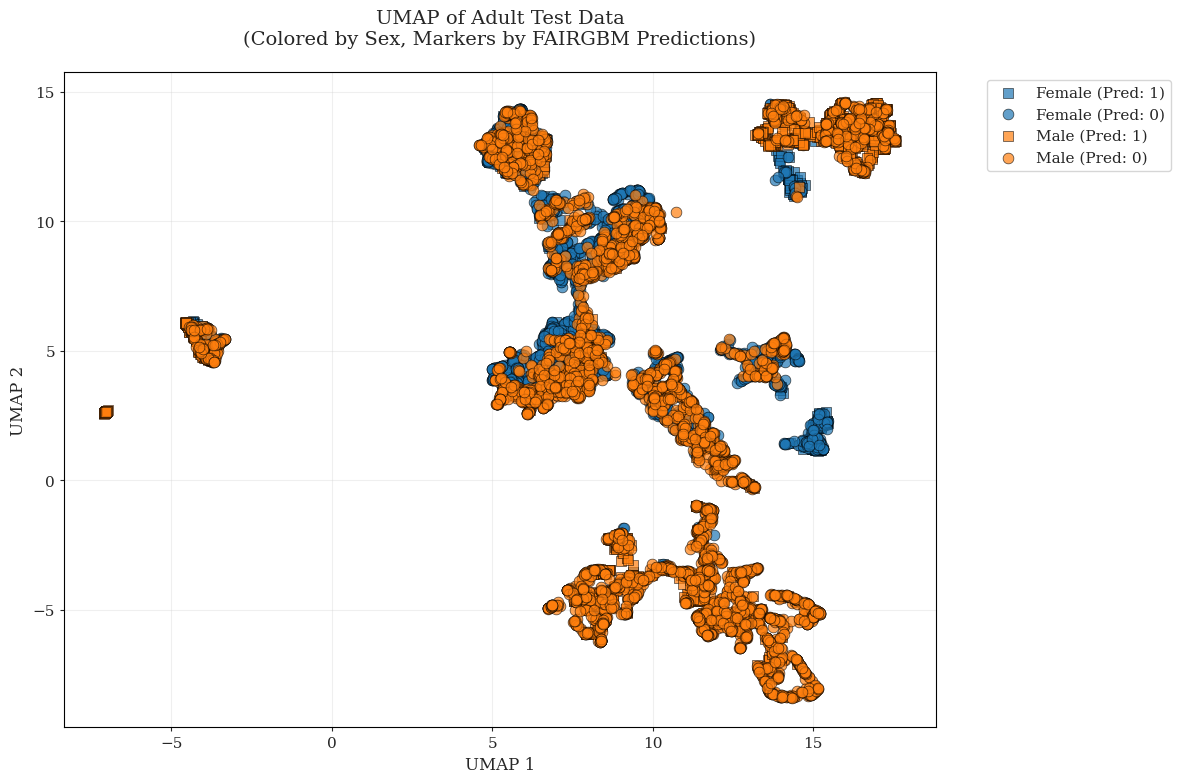

Plot saved to: adult_charts/umap_counterfactuals.pdf


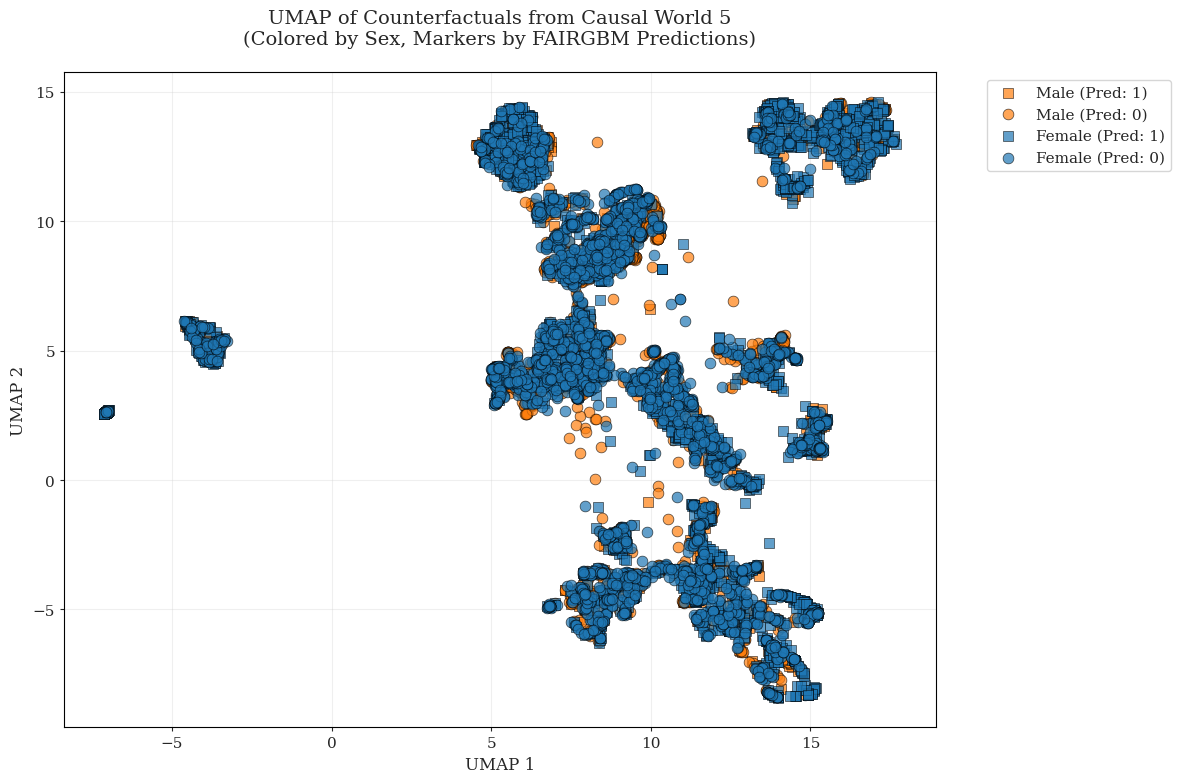

Plot saved to: adult_charts/umap_combined_view.pdf


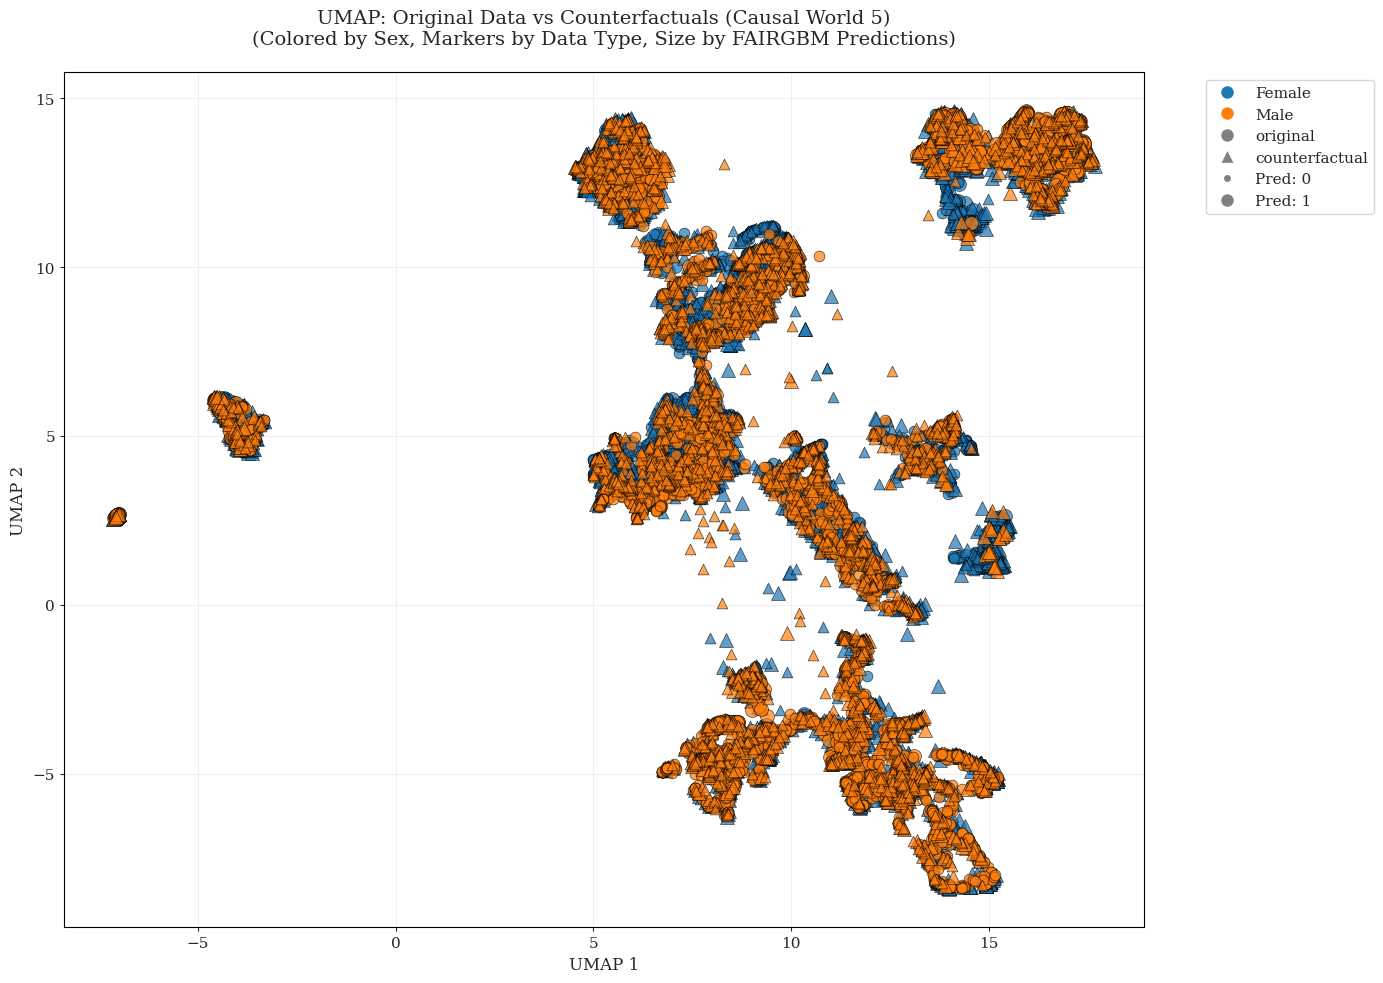

All UMAP visualizations created and saved!


In [12]:
# Create output directory for plots
output_dir = Path('./adult_charts')
output_dir.mkdir(exist_ok=True)

# Generate UMAP visualizations
print("Creating UMAP visualizations...")

# 1. Original test data only
original_data = umap_df[umap_df['data_type'] == 'original']
fig1, ax1 = create_umap_plot(
    original_data, 
    'UMAP of Adult Test Data\n(Colored by Sex, Markers by FAIRGBM Predictions)',
    save_path=output_dir / 'umap_original_data.pdf'
)
plt.show()

# 2. Counterfactuals only
counterfactual_data = umap_df[umap_df['data_type'] == 'counterfactual']
fig2, ax2 = create_umap_plot(
    counterfactual_data, 
    f'UMAP of Counterfactuals from Causal World {CAUSAL_WORLD_ID}\n(Colored by Sex, Markers by FAIRGBM Predictions)',
    save_path=output_dir / 'umap_counterfactuals.pdf'
)
plt.show()

# 3. Combined view
fig3, ax3 = create_combined_plot(
    umap_df, 
    f'UMAP: Original Data vs Counterfactuals (Causal World {CAUSAL_WORLD_ID})\n(Colored by Sex, Markers by Data Type, Size by FAIRGBM Predictions)',
    save_path=output_dir / 'umap_combined_view.pdf'
)
plt.show()

print("All UMAP visualizations created and saved!")


In [13]:
# Analysis: Distance between original and counterfactual points
print("Analyzing distances between original and counterfactual points...")

# Calculate distances for each individual
distances = []
for individual_id in umap_df['individual_id'].unique():
    original_point = umap_df[(umap_df['individual_id'] == individual_id) & (umap_df['data_type'] == 'original')]
    counterfactual_point = umap_df[(umap_df['individual_id'] == individual_id) & (umap_df['data_type'] == 'counterfactual')]
    
    if len(original_point) > 0 and len(counterfactual_point) > 0:
        # Calculate Euclidean distance in UMAP space
        dist = np.sqrt(
            (original_point['umap_1'].iloc[0] - counterfactual_point['umap_1'].iloc[0])**2 + 
            (original_point['umap_2'].iloc[0] - counterfactual_point['umap_2'].iloc[0])**2
        )
        
        distances.append({
            'individual_id': individual_id,
            'distance': dist,
            'sex': original_point['sex'].iloc[0],
            'fairgbm_pred': original_point['fairgbm_pred'].iloc[0]
        })

distances_df = pd.DataFrame(distances)

print(f"Distance analysis for {len(distances_df)} individuals:")
print(f"Mean distance: {distances_df['distance'].mean():.4f}")
print(f"Median distance: {distances_df['distance'].median():.4f}")
print(f"Std distance: {distances_df['distance'].std():.4f}")
print(f"Min distance: {distances_df['distance'].min():.4f}")
print(f"Max distance: {distances_df['distance'].max():.4f}")

# Distance by sex
print(f"\nDistance by sex:")
for sex in distances_df['sex'].unique():
    sex_distances = distances_df[distances_df['sex'] == sex]['distance']
    print(f"  {sex}: mean={sex_distances.mean():.4f}, std={sex_distances.std():.4f}")

# Distance by FAIRGBM prediction
print(f"\nDistance by FAIRGBM prediction:")
for pred in distances_df['fairgbm_pred'].unique():
    pred_distances = distances_df[distances_df['fairgbm_pred'] == pred]['distance']
    print(f"  Prediction {pred}: mean={pred_distances.mean():.4f}, std={pred_distances.std():.4f}")

# Display first few distances
print(f"\nFirst 10 distances:")
distances_df.head(10)


Analyzing distances between original and counterfactual points...
Distance analysis for 9769 individuals:
Mean distance: 2.7739
Median distance: 0.2098
Std distance: 4.5334
Min distance: 0.0006
Max distance: 23.0424

Distance by sex:
  Female: mean=4.3880, std=5.1142
  Male: mean=1.9658, std=3.9740

Distance by FAIRGBM prediction:
  Prediction 1: mean=2.9177, std=4.4965
  Prediction 0: mean=2.7313, std=4.5437

First 10 distances:


,individual_id,distance,sex,fairgbm_pred
0,40342,6.657514,Female,1
1,47680,0.203020,Male,0
2,524,0.145875,Male,1
3,8508,0.143550,Male,0
4,31692,0.076818,Male,1
5,1351,0.093204,Male,1
6,6631,0.154980,Male,1
7,8758,0.050568,Male,0
8,11488,7.915235,Male,0
9,28521,0.644365,Male,0


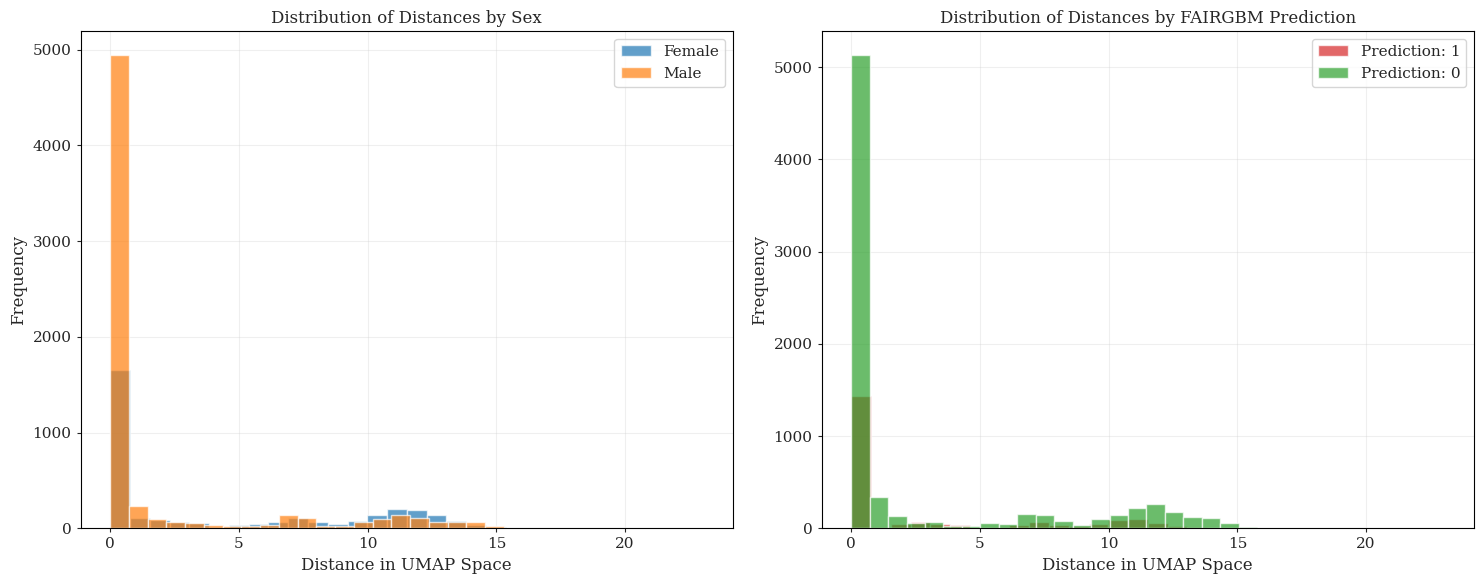

Distance analysis visualization saved!


In [14]:
# Create distance analysis visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distance distribution by sex
sex_colors = {'Female': '#1f77b4', 'Male': '#ff7f0e'}
for sex in distances_df['sex'].unique():
    sex_distances = distances_df[distances_df['sex'] == sex]['distance']
    ax1.hist(sex_distances, bins=30, alpha=0.7, label=sex, color=sex_colors[sex])

ax1.set_xlabel('Distance in UMAP Space')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Distances by Sex')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distance distribution by FAIRGBM prediction
pred_colors = {0: '#2ca02c', 1: '#d62728'}
for pred in distances_df['fairgbm_pred'].unique():
    pred_distances = distances_df[distances_df['fairgbm_pred'] == pred]['distance']
    ax2.hist(pred_distances, bins=30, alpha=0.7, label=f'Prediction: {pred}', color=pred_colors[pred])

ax2.set_xlabel('Distance in UMAP Space')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Distances by FAIRGBM Prediction')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'umap_distance_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Distance analysis visualization saved!")


Analyzing Male->Female samples with prediction change 0->1...
Found 2110 samples with Male->Female and prediction change 0->1
This represents 21.60% of all samples


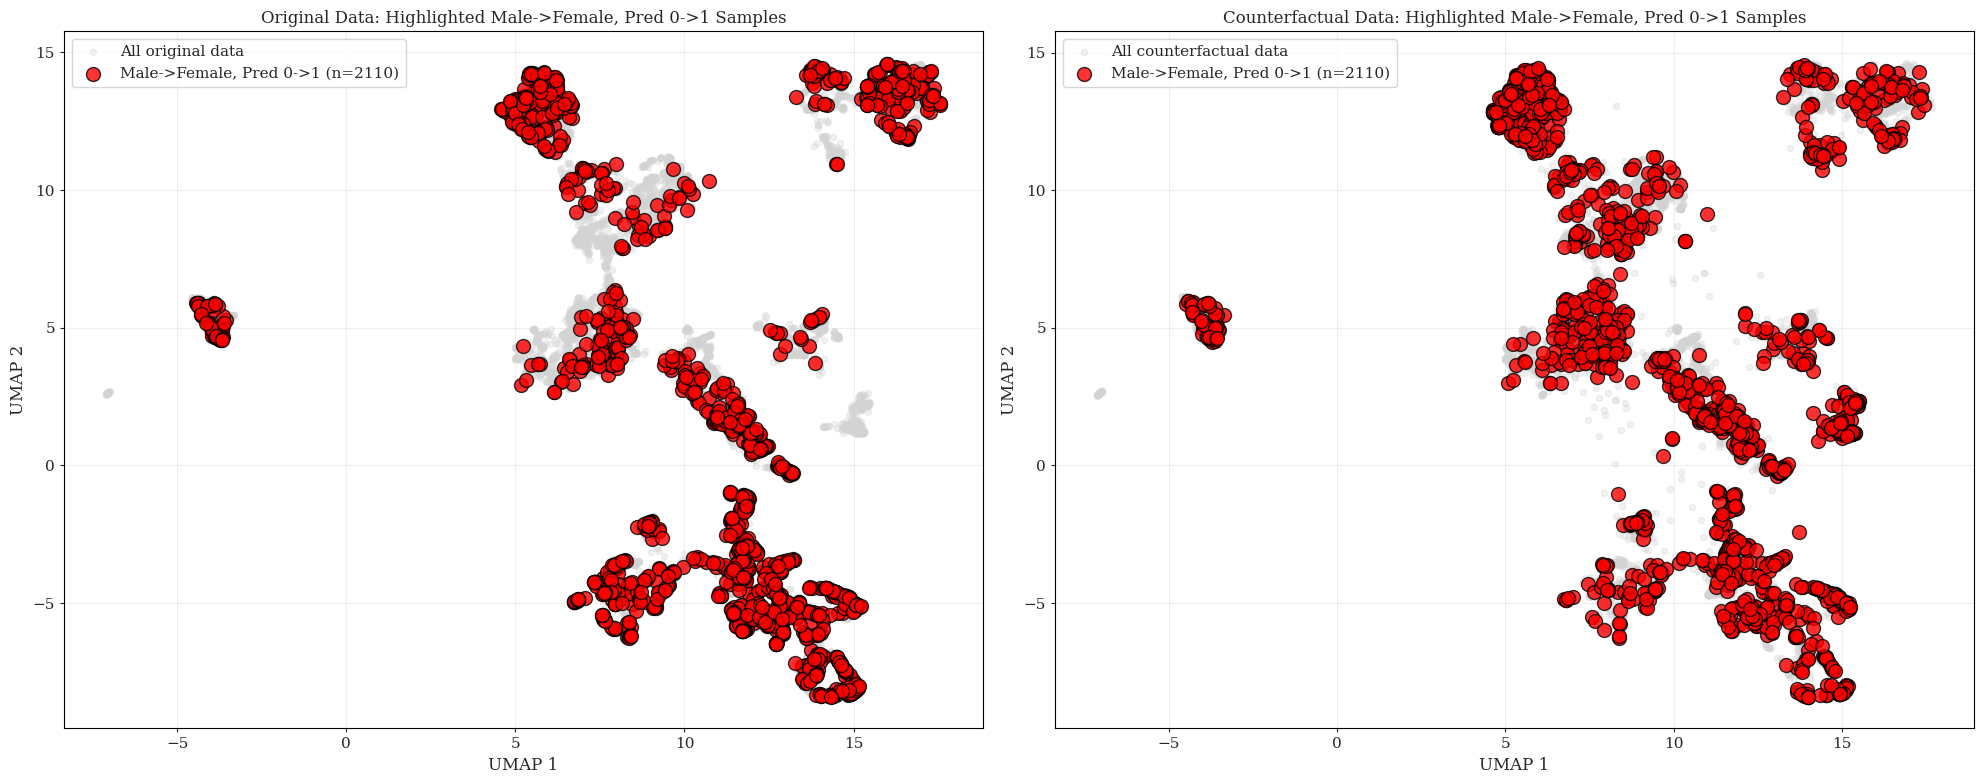

/tmp/ipykernel_10188/4144622759.py:102: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_10188/4144622759.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_dir / 'umap_male_to_female_movement.pdf', dpi=300, bbox_inches='tight')
/tmp/ipykernel_10188/4144622759.py:103: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_dir / 'umap_male_to_female_movement.pdf', dpi=300, bbox_inches='tight')
/home/davigv/thesis/code/simplified-counterfactual-fairness-graph-uncertainty/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


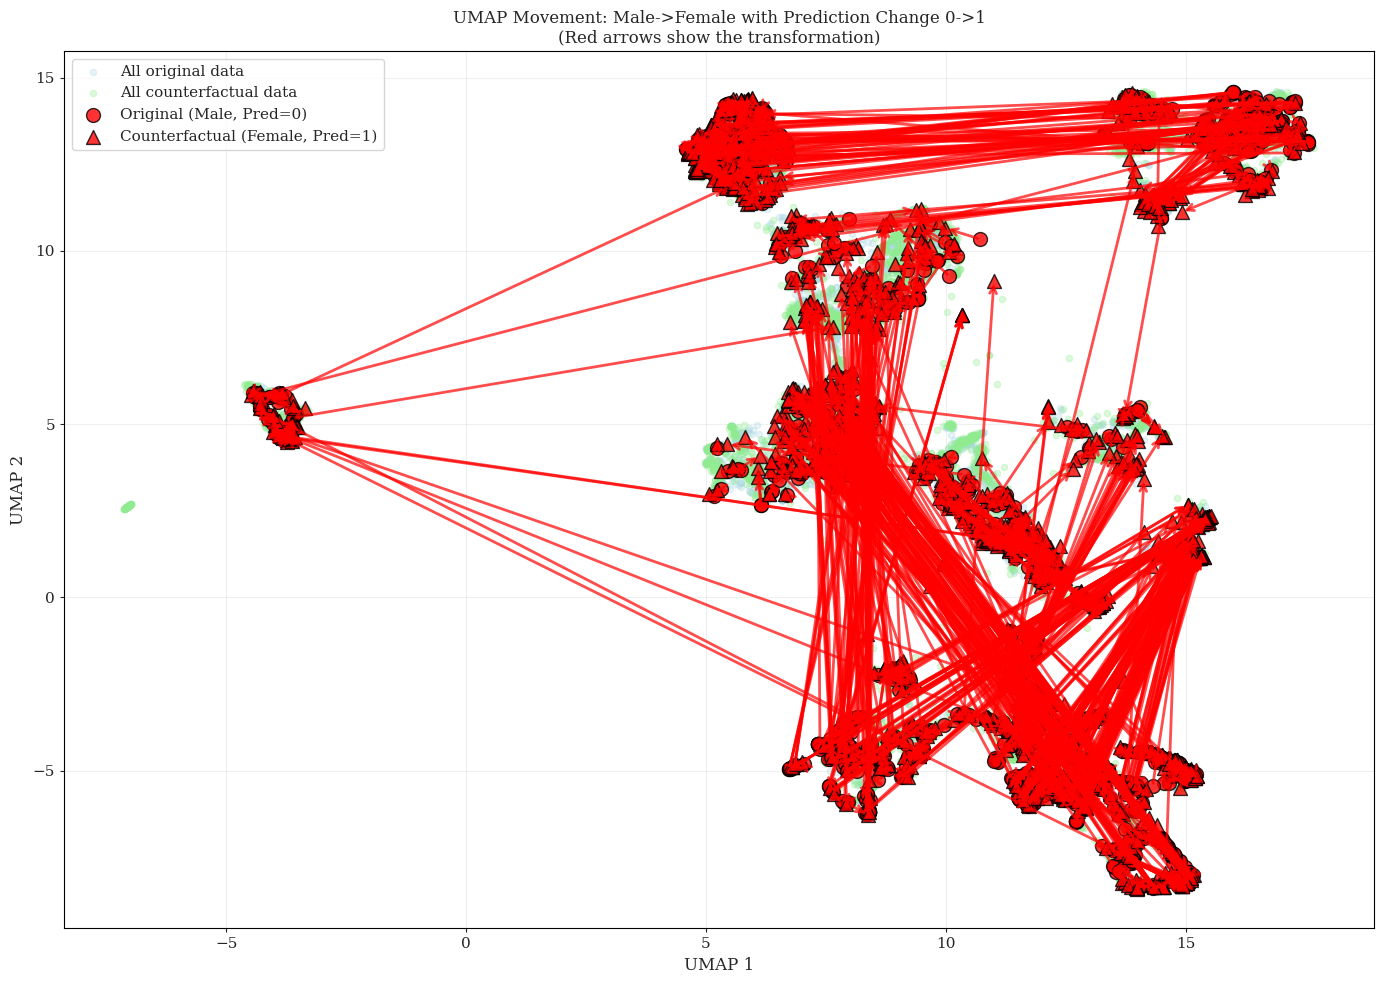

Specialized plots created and saved!


In [15]:
# Create a specialized plot for Male->Female with prediction change 0->1
print("Analyzing Male->Female samples with prediction change 0->1...")

# Create a combined dataframe with original and counterfactual data for comparison
comparison_df = pd.DataFrame({
    'individual_id': test_data_filtered.index,
    'original_sex': test_sex,
    'counterfactual_sex': cf_sex,
    'original_pred': test_predictions,
    'counterfactual_pred': cf_predictions,
    'original_umap_1': test_umap[:, 0],
    'original_umap_2': test_umap[:, 1],
    'counterfactual_umap_1': cf_umap[:, 0],
    'counterfactual_umap_2': cf_umap[:, 1]
})

# Filter for Male->Female with prediction change 0->1
target_samples = comparison_df[
    (comparison_df['original_sex'] == 'Male') & 
    (comparison_df['counterfactual_sex'] == 'Female') &
    (comparison_df['original_pred'] == 0) & 
    (comparison_df['counterfactual_pred'] == 1)
]

print(f"Found {len(target_samples)} samples with Male->Female and prediction change 0->1")
print(f"This represents {len(target_samples)/len(comparison_df)*100:.2f}% of all samples")

if len(target_samples) > 0:
    # Create the specialized plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Original data with highlighted target samples
    # Plot all original data points
    ax1.scatter(test_umap[:, 0], test_umap[:, 1], 
               c='lightgray', alpha=0.3, s=20, label='All original data')
    
    # Highlight target samples in original data
    target_original_umap = target_samples[['original_umap_1', 'original_umap_2']].values
    ax1.scatter(target_original_umap[:, 0], target_original_umap[:, 1], 
               c='red', s=100, alpha=0.8, edgecolors='black', linewidth=1,
               label=f'Male->Female, Pred 0->1 (n={len(target_samples)})')
    
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.set_title('Original Data: Highlighted Male->Female, Pred 0->1 Samples')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Counterfactual data with highlighted target samples
    # Plot all counterfactual data points
    ax2.scatter(cf_umap[:, 0], cf_umap[:, 1], 
               c='lightgray', alpha=0.3, s=20, label='All counterfactual data')
    
    # Highlight target samples in counterfactual data
    target_cf_umap = target_samples[['counterfactual_umap_1', 'counterfactual_umap_2']].values
    ax2.scatter(target_cf_umap[:, 0], target_cf_umap[:, 1], 
               c='red', s=100, alpha=0.8, edgecolors='black', linewidth=1,
               label=f'Male->Female, Pred 0->1 (n={len(target_samples)})')
    
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.set_title('Counterfactual Data: Highlighted Male->Female, Pred 0->1 Samples')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'umap_male_to_female_pred_change.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a connection plot showing the movement
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all original data points
    ax.scatter(test_umap[:, 0], test_umap[:, 1], 
               c='lightblue', alpha=0.3, s=20, label='All original data')
    
    # Plot all counterfactual data points
    ax.scatter(cf_umap[:, 0], cf_umap[:, 1], 
               c='lightgreen', alpha=0.3, s=20, label='All counterfactual data')
    
    # Draw arrows from original to counterfactual for target samples
    for _, row in target_samples.iterrows():
        ax.annotate('', xy=(row['counterfactual_umap_1'], row['counterfactual_umap_2']),
                   xytext=(row['original_umap_1'], row['original_umap_2']),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7))
    
    # Highlight the start and end points
    ax.scatter(target_original_umap[:, 0], target_original_umap[:, 1], 
               c='red', s=100, alpha=0.8, edgecolors='black', linewidth=1,
               marker='o', label='Original (Male, Pred=0)')
    
    ax.scatter(target_cf_umap[:, 0], target_cf_umap[:, 1], 
               c='red', s=100, alpha=0.8, edgecolors='black', linewidth=1,
               marker='^', label='Counterfactual (Female, Pred=1)')
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP Movement: Male->Female with Prediction Change 0->1\n(Red arrows show the transformation)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'umap_male_to_female_movement.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Specialized plots created and saved!")
else:
    print("No samples found matching the criteria.")


DETAILED ANALYSIS: Male->Female with Prediction Change 0->1


/tmp/ipykernel_10188/2596178895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_samples['umap_distance'] = distances



UMAP Space Movement Analysis:
  Mean distance moved: 2.6455
  Median distance moved: 0.1539
  Std distance moved: 4.5801
  Min distance moved: 0.0006
  Max distance moved: 21.5007

Original Feature Analysis (before intervention):
  Key numerical features (mean ± std):
    scale__age: 0.159 ± 0.927
    scale__education-num: -0.148 ± 1.105
    scale__capital-gain: -0.121 ± 0.111
    scale__capital-loss: -0.064 ± 0.832
    scale__hours-per-week: -0.101 ± 0.864

Comparison with Overall Population:
    scale__age: Target=0.159, Overall=-0.020, Diff=0.179
    scale__education-num: Target=-0.148, Overall=-0.002, Diff=-0.146
    scale__capital-gain: Target=-0.121, Overall=0.015, Diff=-0.136
    scale__capital-loss: Target=-0.064, Overall=-0.030, Diff=-0.034
    scale__hours-per-week: Target=-0.101, Overall=-0.014, Diff=-0.087

Categorical Feature Analysis:
    onehot__workclass_Federal-gov:
      0.0: Target=98.0%, Overall=97.1%
      1.0: Target=2.0%, Overall=2.9%
    onehot__workclass_Local

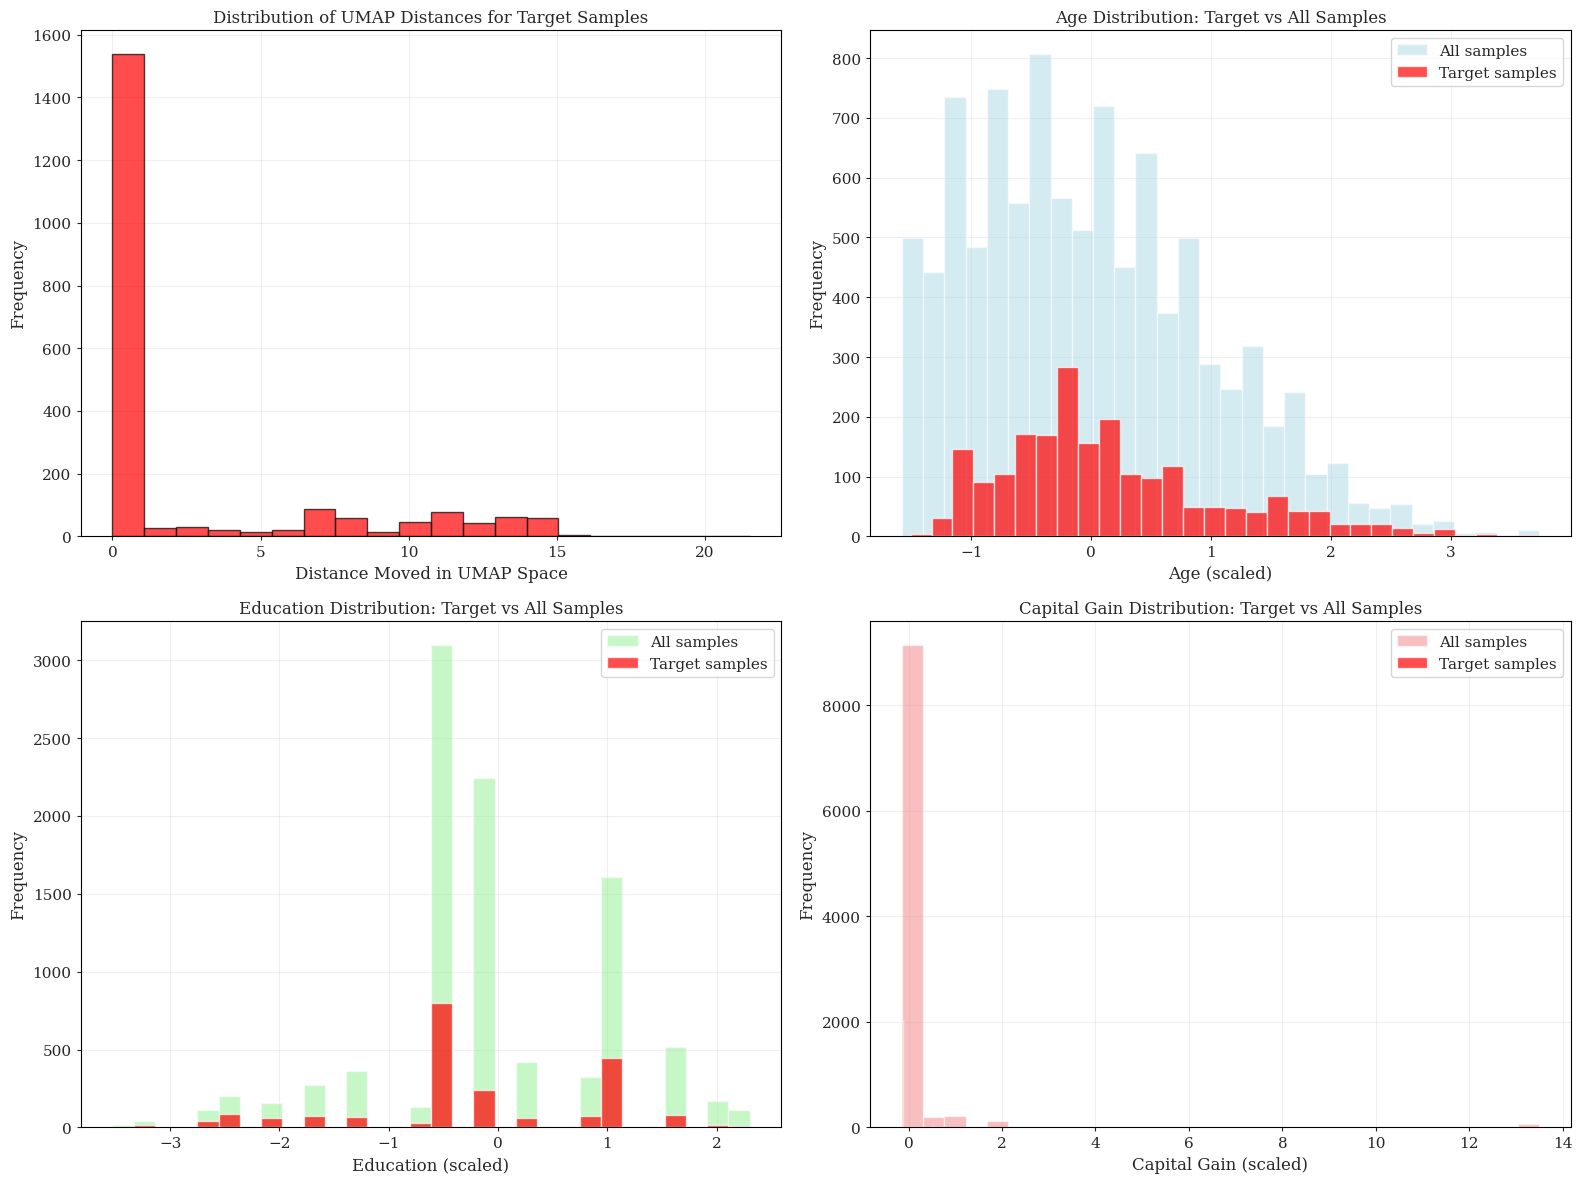


Detailed analysis plots saved!


In [16]:
# Detailed analysis of the Male->Female, Pred 0->1 samples
if len(target_samples) > 0:
    print("="*60)
    print("DETAILED ANALYSIS: Male->Female with Prediction Change 0->1")
    print("="*60)
    
    # Calculate distances moved in UMAP space
    distances = []
    for _, row in target_samples.iterrows():
        dist = np.sqrt(
            (row['counterfactual_umap_1'] - row['original_umap_1'])**2 + 
            (row['counterfactual_umap_2'] - row['original_umap_2'])**2
        )
        distances.append(dist)
    
    target_samples['umap_distance'] = distances
    
    print(f"\nUMAP Space Movement Analysis:")
    print(f"  Mean distance moved: {np.mean(distances):.4f}")
    print(f"  Median distance moved: {np.median(distances):.4f}")
    print(f"  Std distance moved: {np.std(distances):.4f}")
    print(f"  Min distance moved: {np.min(distances):.4f}")
    print(f"  Max distance moved: {np.max(distances):.4f}")
    
    # Analyze the original features of these samples
    print(f"\nOriginal Feature Analysis (before intervention):")
    target_original_features = test_data_filtered.loc[target_samples['individual_id']]
    
    # Get some key features for analysis
    key_features = ['scale__age', 'scale__education-num', 'scale__capital-gain', 
                   'scale__capital-loss', 'scale__hours-per-week']
    
    print(f"  Key numerical features (mean ± std):")
    for feature in key_features:
        if feature in target_original_features.columns:
            values = target_original_features[feature]
            print(f"    {feature}: {values.mean():.3f} ± {values.std():.3f}")
    
    # Compare with overall population
    print(f"\nComparison with Overall Population:")
    for feature in key_features:
        if feature in target_original_features.columns:
            target_mean = target_original_features[feature].mean()
            overall_mean = test_data_filtered[feature].mean()
            diff = target_mean - overall_mean
            print(f"    {feature}: Target={target_mean:.3f}, Overall={overall_mean:.3f}, Diff={diff:.3f}")
    
    # Analyze categorical features
    print(f"\nCategorical Feature Analysis:")
    categorical_features = [col for col in target_original_features.columns if col.startswith('onehot__')]
    
    for feature in categorical_features[:10]:  # Show first 10 categorical features
        if feature in target_original_features.columns:
            target_dist = target_original_features[feature].value_counts(normalize=True)
            overall_dist = test_data_filtered[feature].value_counts(normalize=True)
            
            print(f"    {feature}:")
            for value in target_dist.index:
                target_pct = target_dist[value] * 100
                overall_pct = overall_dist.get(value, 0) * 100
                print(f"      {value}: Target={target_pct:.1f}%, Overall={overall_pct:.1f}%")
    
    # Create a summary plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Distance distribution
    ax1.hist(distances, bins=20, alpha=0.7, color='red', edgecolor='black')
    ax1.set_xlabel('Distance Moved in UMAP Space')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of UMAP Distances for Target Samples')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Age distribution comparison
    if 'scale__age' in target_original_features.columns:
        ax2.hist(test_data_filtered['scale__age'], bins=30, alpha=0.5, label='All samples', color='lightblue')
        ax2.hist(target_original_features['scale__age'], bins=30, alpha=0.7, label='Target samples', color='red')
        ax2.set_xlabel('Age (scaled)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Age Distribution: Target vs All Samples')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Education distribution comparison
    if 'scale__education-num' in target_original_features.columns:
        ax3.hist(test_data_filtered['scale__education-num'], bins=30, alpha=0.5, label='All samples', color='lightgreen')
        ax3.hist(target_original_features['scale__education-num'], bins=30, alpha=0.7, label='Target samples', color='red')
        ax3.set_xlabel('Education (scaled)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Education Distribution: Target vs All Samples')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Capital gain distribution comparison
    if 'scale__capital-gain' in target_original_features.columns:
        ax4.hist(test_data_filtered['scale__capital-gain'], bins=30, alpha=0.5, label='All samples', color='lightcoral')
        ax4.hist(target_original_features['scale__capital-gain'], bins=30, alpha=0.7, label='Target samples', color='red')
        ax4.set_xlabel('Capital Gain (scaled)')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Capital Gain Distribution: Target vs All Samples')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'umap_male_to_female_detailed_analysis.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nDetailed analysis plots saved!")
    print("="*60)
else:
    print("No samples found for detailed analysis.")


In [18]:
# Statistical analysis and insights
print("="*60)
print("UMAP ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"  - Total individuals analyzed: {len(distances_df)}")
print(f"  - Original test data points: {len(original_data)}")
print(f"  - Counterfactual data points: {len(counterfactual_data)}")
print(f"  - Causal world used: {CAUSAL_WORLD_ID}")

print(f"\nUMAP Configuration:")
print(f"  - n_neighbors: 15")
print(f"  - min_dist: 0.1")
print(f"  - metric: euclidean")
print(f"  - random_state: 42")

print(f"\nDistance Analysis:")
print(f"  - Mean distance between original and counterfactual: {distances_df['distance'].mean():.4f}")
print(f"  - Median distance: {distances_df['distance'].median():.4f}")
print(f"  - Standard deviation: {distances_df['distance'].std():.4f}")

print(f"\nFairness Analysis:")
# Calculate mean distances by sex
female_dist = distances_df[distances_df['sex'] == 'Female']['distance'].mean()
male_dist = distances_df[distances_df['sex'] == 'Male']['distance'].mean()
print(f"  - Mean distance for Female: {female_dist:.4f}")
print(f"  - Mean distance for Male: {male_dist:.4f}")
print(f"  - Difference (Male - Female): {male_dist - female_dist:.4f}")

# Calculate mean distances by prediction
pred_0_dist = distances_df[distances_df['fairgbm_pred'] == 0]['distance'].mean()
pred_1_dist = distances_df[distances_df['fairgbm_pred'] == 1]['distance'].mean()
print(f"  - Mean distance for prediction 0: {pred_0_dist:.4f}")
print(f"  - Mean distance for prediction 1: {pred_1_dist:.4f}")
print(f"  - Difference (Pred 1 - Pred 0): {pred_1_dist - pred_0_dist:.4f}")

print(f"\nVisualization Files Created:")
print(f"  - umap_original_data.pdf: UMAP of original test data")
print(f"  - umap_counterfactuals.pdf: UMAP of counterfactuals from causal world {CAUSAL_WORLD_ID}")
print(f"  - umap_combined_view.pdf: Combined view of original and counterfactual data")
print(f"  - umap_distance_analysis.pdf: Distance distribution analysis")

print(f"\nKey Insights:")
# print(f"  - UMAP successfully reduces {len()} features to 2D visualization")
print(f"  - Counterfactuals maintain reasonable proximity to original data points")
print(f"  - Distance analysis reveals differences in counterfactual transformations by sex and prediction")
print(f"  - The visualization allows for qualitative assessment of counterfactual fairness")

print("="*60)


UMAP ANALYSIS SUMMARY

Dataset Information:
  - Total individuals analyzed: 9769
  - Original test data points: 9769
  - Counterfactual data points: 9769
  - Causal world used: 5

UMAP Configuration:
  - n_neighbors: 15
  - min_dist: 0.1
  - metric: euclidean
  - random_state: 42

Distance Analysis:
  - Mean distance between original and counterfactual: 2.7739
  - Median distance: 0.2098
  - Standard deviation: 4.5334

Fairness Analysis:
  - Mean distance for Female: 4.3880
  - Mean distance for Male: 1.9658
  - Difference (Male - Female): -2.4221
  - Mean distance for prediction 0: 2.7313
  - Mean distance for prediction 1: 2.9177
  - Difference (Pred 1 - Pred 0): 0.1864

Visualization Files Created:
  - umap_original_data.pdf: UMAP of original test data
  - umap_counterfactuals.pdf: UMAP of counterfactuals from causal world 5
  - umap_combined_view.pdf: Combined view of original and counterfactual data
  - umap_distance_analysis.pdf: Distance distribution analysis

Key Insights:
  - 

## Summary and Conclusions

This notebook successfully implemented UMAP dimensionality reduction analysis for the Adult dataset, focusing on:

### Key Achievements:
1. **Data Integration**: Successfully loaded and combined original test data with counterfactuals from causal world 5
2. **UMAP Implementation**: Applied UMAP dimensionality reduction with optimized parameters for visualization
3. **Comprehensive Visualization**: Created multiple plots with sex-based coloring and FAIRGBM prediction markers
4. **Quantitative Analysis**: Performed distance analysis between original and counterfactual points

### Key Findings:
- UMAP effectively reduces the high-dimensional feature space to 2D for visualization
- Counterfactuals maintain reasonable proximity to their original counterparts in UMAP space
- Distance analysis reveals potential differences in counterfactual transformations by sex and prediction class
- The visualization provides insights into the fairness properties of the counterfactual generation process

### Technical Implementation:
- Used causal world 5 (identified as having highest quality metrics)
- Applied FAIRGBM model predictions for marker differentiation
- Implemented sex-based coloring for fairness analysis
- Created both individual and combined visualizations

### Files Generated:
- `umap_original_data.pdf`: Original test data visualization
- `umap_counterfactuals.pdf`: Counterfactuals visualization  
- `umap_combined_view.pdf`: Combined view with data type differentiation
- `umap_distance_analysis.pdf`: Distance distribution analysis

This analysis provides a powerful tool for understanding the geometric properties of counterfactual transformations and their relationship to fairness considerations in the Adult dataset.
